In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
from fastai.vision import *
import pretrainedmodels

In [3]:
from utils import FocalLoss
from imbalanced_sampler import ImbalancedDatasetSampler

In [4]:
path = Path('.')

In [5]:
train = path/'train_dehaze/'
test =  path/'leaderboard_test_data_dehaze/'
holdout = path/'leaderboard_holdout_data_dehaze/'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [6]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]

In [7]:
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [8]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [9]:
(df.has_oilpalm==1).sum()

942

In [10]:
from fastai.torch_core import flatten_model

def inceptionv4(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['inceptionv4'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers[0], *all_layers[1:])

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [11]:
def get_data(df, size=128, bs=64, pct=0.2, seed=2019):
    data = (ImageItemList.from_df(df, path, folder=train)
           .random_split_by_pct(pct, seed=seed)
           .label_from_df('has_oilpalm')
           .add_test(test_names+holdout_names)
           .transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=size))
    
    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], func=np.log)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl=train_dl, valid_dl=val_dl, test_dl=test_dl).normalize(imagenet_stats)

In [36]:
#This was working perfectly some minutes ago!
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric

def get_learner(data, mixup=True, fp16=True):
    learn = create_cnn(data, 
                       inceptionv4,
                       pretrained=True,
                       loss_func=FocalLoss(gamma=2),
                       metrics=[accuracy],
                       cut=-2, 
                       split_on=lambda m: (m[0][11], m[1]))
    if mixup: learn.mixup()
    if fp16: return learn.to_fp16()
    else: return learn

In [37]:
data = get_data(df, 256, 64)

In [38]:
learn = get_learner(data, mixup=True)

In [39]:
get_groups(nn.Sequential(*learn.model[0], *learn.model[1]), learn.layer_groups)

Group 1: ['BasicConv2d', 'BasicConv2d', 'BasicConv2d', 'Mixed_3a', 'Mixed_4a', 'Mixed_5a', 'Inception_A', 'Inception_A', 'Inception_A', 'Inception_A', 'Reduction_A']
Group 2: ['Inception_B', 'Inception_B', 'Inception_B', 'Inception_B', 'Inception_B', 'Inception_B', 'Inception_B', 'Reduction_B', 'Inception_C', 'Inception_C', 'Inception_C']
Group 3: ['AdaptiveConcatPool2d', 'Flatten', 'BatchNorm1d', 'Dropout', 'Linear', 'ReLU', 'BatchNorm1d', 'Dropout', 'Linear']


In [40]:
learn.loss_func

MixUpLoss(
  (crit): FocalLoss()
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02


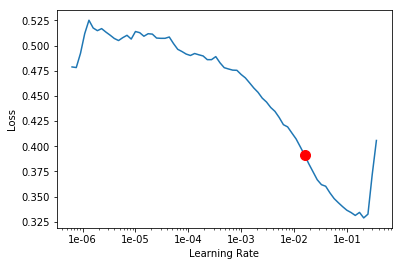

In [41]:
learn.lr_find(); learn.recorder.plot()

In [42]:
lr = 1e-2

256

In [ ]:
learn.fit_one_cycle(6, lr)
learn.save('256')

epoch,train_loss,valid_loss,accuracy
1,0.065903,0.066416,0.971785
2,0.053722,0.032082,0.982940


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


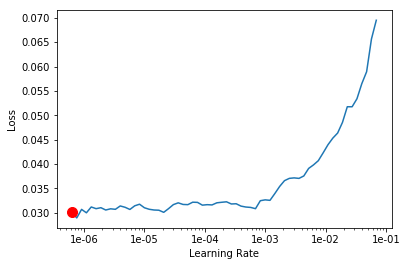

In [33]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [35]:
learn.fit_one_cycle(6, slice(1e-5,1e-3))
learn.save('256u')

epoch,train_loss,valid_loss,accuracy
1,0.032515,0.012115,0.989829
2,0.034592,0.011183,0.989501
3,0.032387,0.013796,0.986877
4,0.032338,0.014500,0.988845
5,0.031343,0.012828,0.989829
6,0.031351,0.012753,0.990486


Results

In [63]:
learn = get_learner(data, mixup=False)
learn.load('256u');

[(1, 0, 19), (0, 1, 6)]

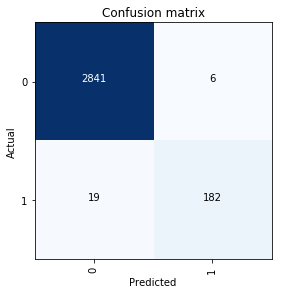

In [64]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()

In [155]:
def get_hard(learn):
    interp_val = ClassificationInterpretation.from_learner(learn)
    interp_train = ClassificationInterpretation.from_learner(learn, DatasetType.Train)
    fn, fp = interp_val.most_confused()
    n1 = fn[2]+fp[2]
    fn, fp = interp_train.most_confused()
    n2 = fn[2]+fp[2]
    print(f'Hard images count : {n1+n2}')
    losses, idxs_val = interp_val.top_losses(int(n1))
    losses, idxs_train = interp_train.top_losses(int(n2))

    hard_images_val = data.valid_ds.items[idxs_val]
    hard_images_train = data.train_ds.items[idxs_train]

    hard_images_names = [f[-17:] for f in hard_images_train] + [f[-17:] for f in hard_images_val]; hard_images_names[0:3]
    return hard_images_names

In [127]:
hard_images_names = get_hard(learn)

df2 = df.set_index('image_id')
df2 = df2.loc[hard_images_names]
df2.reset_index().to_csv('hard_examples.csv', index=False)

In [129]:
df2 = pd.read_csv('hard_examples.csv')

In [147]:
data = get_data(df2, 256, 8, 0.1)

In [148]:
learn = get_learner(data, mixup=False)

In [150]:
learn.load('256u');
learn.fit_one_cycle(10, slice(1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.830727,0.731791,0.714286
2,0.696769,0.998761,0.714286
3,0.703259,0.810313,0.714286
4,0.718831,0.863657,0.714286
5,0.751492,0.981853,0.714286
6,0.730802,0.960614,0.714286
7,0.748094,0.968285,0.714286
8,0.805078,1.015375,0.714286
9,0.744649,0.897016,0.714286
10,0.738353,0.849498,0.714286


In [151]:
learn.save('hard')

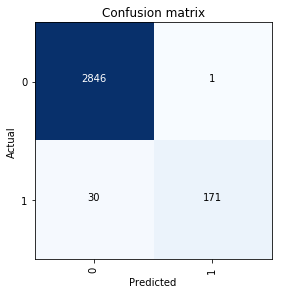

In [152]:
data = get_data(df, 256, 64)
learn = get_learner(data, mixup=False)
learn.load('hard')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Sub file

In [16]:
ids = np.array([f.name for f in test_names]+[f.name for f in holdout_names])

In [17]:
ids.shape

(6534,)

In [18]:
sub = pd.DataFrame(np.stack([ids, preds], axis=1), columns=df_sample.columns)

In [19]:
sub.to_csv('sub_resneXt101x5_haze_TTA.csv', index=False)

In [24]:
sub.has_oilpalm.asdtype(float)

AttributeError: 'Series' object has no attribute 'asdtype'